# thực hiện input và tiền xử lý dữ liệu

In [ ]:
#use for google collab for mounting file from driver/ nếu không dùng colab thì không dùng block này
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
# nếu chạy trên colab thì sẽ có sẵn và không phải chạy block này
!pip install numpy
!pip install pandas
!pip install researchpy
!pip install mlxtend
!pip install seaborn
!pip install researchpy
!pip install scipy
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.4 MB/s eta 0:00:00a 0:00:010m


In [2]:
import numpy as np # thư viện đại số tuyến tính của python
import pandas as pd # thư viện xử lý dữ liệu 

# ấn shift + enter để chạy hoặc ấn vào nút play bên trái. 

# path_to_dataset='/content/drive/MyDrive/Dataset'
path_to_dataset='./Dataset'

import os
for dirname, _, filenames in os.walk(path_to_dataset): #Or you can upload the dataset to this folder /content/Dataset and uncomment the above line
    for filename in filenames:
        print(os.path.join(dirname, filename))

#

./Dataset/Market_Basket_Optimisation.csv


Các công ty sẽ muốn từ tập dữ liệu mà họ thu thập được, tìm ra các items hay được mua cùng với nhau, qua đó có thể thực hiện việc tạo combo, xếp cùng các vật phẩm hay được mua cùng để người dùng không bị bỏ quên khi thực hiện mua hàng, đẩy số lượng hàng được bán lên,... tất cả để nhằm mục đích tăng lượng sale sản phẩm tăng doanh thu. Để có thể tìm ra được các tri thức như vậy, ta sẽ sử dụng thuật toán apriori và thực hiện đánh giá hiệu năng của các tập luật (tri thức tìm được) bằng cách chia dataset ra thành tập train và tập validate.

Để có thể làm được những điều trên thì chúng em sẽ phải thực hiện các việc như xử lý dataset, tìm mối quan hệ trong dataset và thực hiện visualize, tìm ra tri thức hay tập luật và đánh giá chất lượng tri thức.

Các vấn đề được xác định gồm:

- Thực hiện phân tích dữ liệu vào
- Xử lý dataset, xác định các thuộc tính cần thiết và không cần thiết.
- Thử nghiệm các param như support và confidence,... đánh giá mức độ tối ưu
- Tìm ra các pattern
- Thực hiện các bước trên nhưng với các param khác đi
- Tìm được ra các tri thức (ở đây là tập luật về các item hay được mua cùng nhau)
- So sánh các tập luật đã được tìm ở các lần thay đổi param.
- Hiểu, tìm được cách giải thích cho các tập luật đã tìm ra.

In [8]:
#thực hiện cài đặt các thư viện sẽ phải sử dụng sau này 
!pip install researchpy
!pip install openpyxl

In [14]:
#thực hiện import các thư viện
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import json
from datetime import datetime
from itertools import combinations, groupby
from collections import Counter
import itertools
import researchpy

import time
import gc
import collections

begin = time.time() # đánh dấu bắt đầu 
gc.collect()

pd.pandas.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
# pd.set_option("precision", 3)
#Sẽ hiển thị 3 số sau dấu , với số thập phân
pd.options.display.float_format = '{:,.3f}'.format

In [15]:
#Nếu thay đổi đường dẫn đến dataset thì hãy cập nhật cả ở đây
#dataframe để thực hiện tìm ra tri thức
# df = pd.read_csv(r'/content/drive/MyDrive/Dataset/Market_Basket_Optimisation.csv', header=None)
df = pd.read_csv(r'./Dataset/Market_Basket_Optimisation.csv', header=None)
#dataframe để thực hiện kiểm tra lại luật
# dft = 
#chạy lệnh này sẽ hiển thị các giao dịch đầu đã được đọc 
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.shape # từ shape ta biết được có tổng thể 7501 giao dịch và một giao dịch có số item được mua lớn nhất là 20

(7501, 20)

In [17]:
df.info() # Data set hiện có rất nhiều trường đang bị null do không phải giao dịch nào cũng chứa cùng lúc 20 vật phẩm

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [18]:
#như đã chạy ở trên df.shape(0) là chỉ số giao dịch hay số dòng trong file, df.shape(1) là chỉ số giao dịch (maximum ở đây là 20)
#ta thực hiện xử lý data nhận được về array records với mỗi hàng là một giao dịch
records = []
for i in range(0, df.shape[0]):
    records.append([str(df.values[i,j]) for j in range(0, df.shape[1])])
    
print([x for x in records[1] if str(x) != 'nan']) #Ta in ra giá trị thứ 2 không có các trường null

['burgers', 'meatballs', 'eggs']


In [19]:
# thực hiện tìm ra các vật phẩm tồn tại trong các giao dịch để tạo ra bảng biểu diễn nhị phân
uniq = []
for col in df.columns:
    uniq.append(list(set(df[col].unique().tolist())))
    
flatItemsList = [item for sublist in uniq for item in sublist]
# print(flatItemsList)

In [20]:
#thực hiện remove các item bị đánh vần sai và tạo list tên vật phẩm độc nhất
print([item for item, count in collections.Counter(flatItemsList).items() if count > 1])

['champagne', 'rice', 'oatmeal', 'cauliflower', 'bug spray', 'fromage blanc', 'pancakes', 'energy drink', 'turkey', 'pickles', 'salad', 'frozen vegetables', 'brownies', 'asparagus', 'fresh bread', 'white wine', 'black tea', 'cake', 'red wine', 'eggs', 'oil', 'ketchup', 'light mayo', 'meatballs', 'butter', 'body spray', 'grated cheese', 'mint', 'salmon', 'mint green tea', 'babies food', 'green grapes', 'nonfat milk', 'tomato sauce', 'chutney', 'bramble', 'cider', 'soup', 'almonds', 'shallot', 'burger sauce', 'chicken', 'frozen smoothie', 'pet food', 'light cream', 'escalope', 'bacon', 'whole weat flour', 'mushroom cream sauce', 'vegetables mix', 'mayonnaise', 'carrots', 'melons', 'eggplant', 'sparkling water', 'cereals', 'soda', 'pepper', 'olive oil', 'herb & pepper', 'toothpaste', 'green beans', 'flax seed', 'mashed potato', 'yogurt cake', 'cottage cheese', 'cookies', 'blueberries', 'french fries', 'sandwich', 'cream', 'hand protein bar', 'avocado', 'muffins', 'honey', 'french wine', '

In [21]:
uniqueItems = list(set(flatItemsList)) # lấy ra các item độc nhất để tạo data frame các giao dịch
uniqueItems[4] # ví dụ energy drink

'bug spray'

In [22]:
uniqueItems = [x for x in uniqueItems if str(x) != 'nan'] # datasets còn chứa các trường có giá trị 'NaN' => loại bỏ
len(uniqueItems) # tìm ra được số item hiện hữu trong các giao dịch

120

In [24]:
# in ra thời gian thực hiện của block
def buildDataset(df, uniqueItems):
    """
    Thực hiện xử lý các giao dịch trong dataset và đưa về dạng bảng nhị phân
    Với 0 thể hiện item không có mặt trong giao dịch, 1 là có xuất hiện trong giao dịch
    Input : List chứa tên các item độc nhất để tạo cột
    Output : DataFrame là bảng nhị phân biểu diễn sự xuất hiện của các item trong giao dịch

    """
    dfCleaned = pd.DataFrame(np.zeros((df.shape[0], len(uniqueItems))), columns=uniqueItems, dtype=np.int32)
    
    for colIdx, item in enumerate(dfCleaned.columns.tolist()): # xử lý một cột
        for rowIdx, row in df.iterrows(): # lấy các item từ dòng đầu tiên của các giao dịch
            rowVals = row.values # so sánh nó với uniqueItems
            if item in rowVals:
                dfCleaned.iloc[rowIdx, colIdx] = 1 # nếu tốn tại thì giá trị đổi bằng 1
            
    return dfCleaned

df = buildDataset(df, uniqueItems)
df.head(3)


,champagne,rice,oatmeal,cauliflower,bug spray,fromage blanc,pancakes,energy drink,zucchini,turkey,pickles,salad,frozen vegetables,brownies,asparagus,white wine,black tea,cake,red wine,eggs,oil,ketchup,light mayo,meatballs,butter,body spray,grated cheese,mint,salmon,mint green tea,babies food,green grapes,nonfat milk,tomato sauce,chutney,bramble,cider,soup,almonds,shallot,burger sauce,chicken,frozen smoothie,pet food,light cream,escalope,bacon,whole weat flour,mushroom cream sauce,vegetables mix,mayonnaise,carrots,melons,eggplant,sparkling water,cereals,soda,tea,pepper,olive oil,herb & pepper,toothpaste,mashed potato,green beans,flax seed,yogurt cake,cottage cheese,cookies,blueberries,french fries,sandwich,cream,hand protein bar,avocado,muffins,honey,french wine,milk,burgers,salt,ham,strawberries,parmesan cheese,hot dogs,extra dark chocolate,spaghetti,dessert wine,gluten free bar,low fat yogurt,barbecue sauce,chocolate bread,candy bars,fresh tuna,corn,chili,ground beef,whole wheat pasta,napkins,antioxydant juice,chocolate,magazines,gums,shrimp,mineral water,whole wheat rice,yams,cooking oil,asparagus,green tea,tomatoes,clothes accessories,water spray,spinach,shampoo,energy bar,tomato juice,strong cheese,protein bar,pasta,fresh bread
0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
df.sum()[:5] # Hiển thị sự xuất hiện của các item

champagne      351
rice           141
oatmeal         33
cauliflower     36
bug spray       65
dtype: int64

In [26]:
df.describe().loc[['mean', 'std']].sort_values(by = 'mean', axis=1, ascending=False) # tính trung bình sự xuất hiện của các item trong 7501 giao dịch
# mineral water; eggs; spaghetti; french fries; chocolate; green tea; milk là các sản phẩm được xuất hiện/ mua nhiều nhất

,mineral water,eggs,spaghetti,french fries,chocolate,green tea,milk,ground beef,frozen vegetables,pancakes,burgers,cake,cookies,escalope,low fat yogurt,shrimp,tomatoes,olive oil,frozen smoothie,turkey,chicken,whole wheat rice,grated cheese,cooking oil,soup,herb & pepper,honey,champagne,fresh bread,salmon,brownies,avocado,hot dogs,cottage cheese,tomato juice,butter,whole wheat pasta,red wine,yogurt cake,light mayo,energy bar,energy drink,ham,pepper,vegetables mix,cereals,muffins,oil,french wine,fresh tuna,strawberries,meatballs,almonds,parmesan cheese,mushroom cream sauce,rice,protein bar,mint,white wine,pasta,light cream,carrots,black tea,tomato sauce,fromage blanc,gums,eggplant,extra dark chocolate,melons,body spray,yams,magazines,barbecue sauce,cider,nonfat milk,candy bars,zucchini,whole weat flour,salt,blueberries,flax seed,green grapes,antioxydant juice,bug spray,bacon,green beans,clothes accessories,toothpaste,strong cheese,shallot,spinach,gluten free bar,pet food,sparkling water,soda,mayonnaise,chili,pickles,burger sauce,mint green tea,hand protein bar,salad,shampoo,corn,cauliflower,asparagus,babies food,sandwich,ketchup,dessert wine,oatmeal,chocolate bread,chutney,mashed potato,tea,bramble,cream,napkins,water spray,asparagus
mean,0.238,0.180,0.174,0.171,0.164,0.132,0.130,0.098,0.095,0.095,0.087,0.081,0.080,0.079,0.077,0.071,0.068,0.066,0.063,0.063,0.060,0.059,0.052,0.051,0.051,0.049,0.047,0.047,0.043,0.043,0.034,0.033,0.032,0.032,0.030,0.030,0.029,0.028,0.027,0.027,0.027,0.027,0.027,0.027,0.026,0.026,0.024,0.023,0.023,0.022,0.021,0.021,0.020,0.020,0.019,0.019,0.019,0.017,0.017,0.016,0.016,0.015,0.014,0.014,0.014,0.013,0.013,0.012,0.012,0.011,0.011,0.011,0.011,0.011,0.010,0.010,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.008,0.008,0.008,0.008,0.007,0.007,0.007,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.002,0.001,0.001,0.000,0.000
std,0.426,0.384,0.379,0.376,0.370,0.339,0.336,0.298,0.294,0.293,0.282,0.273,0.272,0.270,0.266,0.258,0.252,0.248,0.244,0.242,0.237,0.235,0.223,0.220,0.219,0.217,0.213,0.211,0.203,0.202,0.181,0.180,0.177,0.176,0.172,0.171,0.169,0.165,0.163,0.163,0.162,0.161,0.161,0.161,0.158,0.158,0.153,0.150,0.148,0.148,0.144,0.143,0.141,0.140,0.137,0.136,0.135,0.131,0.128,0.124,0.124,0.123,0.119,0.118,0.116,0.115,0.114,0.109,0.109,0.106,0.106,0.104,0.103,0.102,0.101,0.098,0.097,0.096,0.095,0.095,0.095,0.095,0.094,0.093,0.093,0.093,0.091,0.090,0.088,0.088,0.084,0.083,0.081,0.079,0.079,0.078,0.078,0.077,0.076,0.075,0.072,0.070,0.070,0.069,0.069,0.068,0.067,0.067,0.066,0.066,0.066,0.065,0.064,0.064,0.062,0.043,0.031,0.026,0.020,0.012


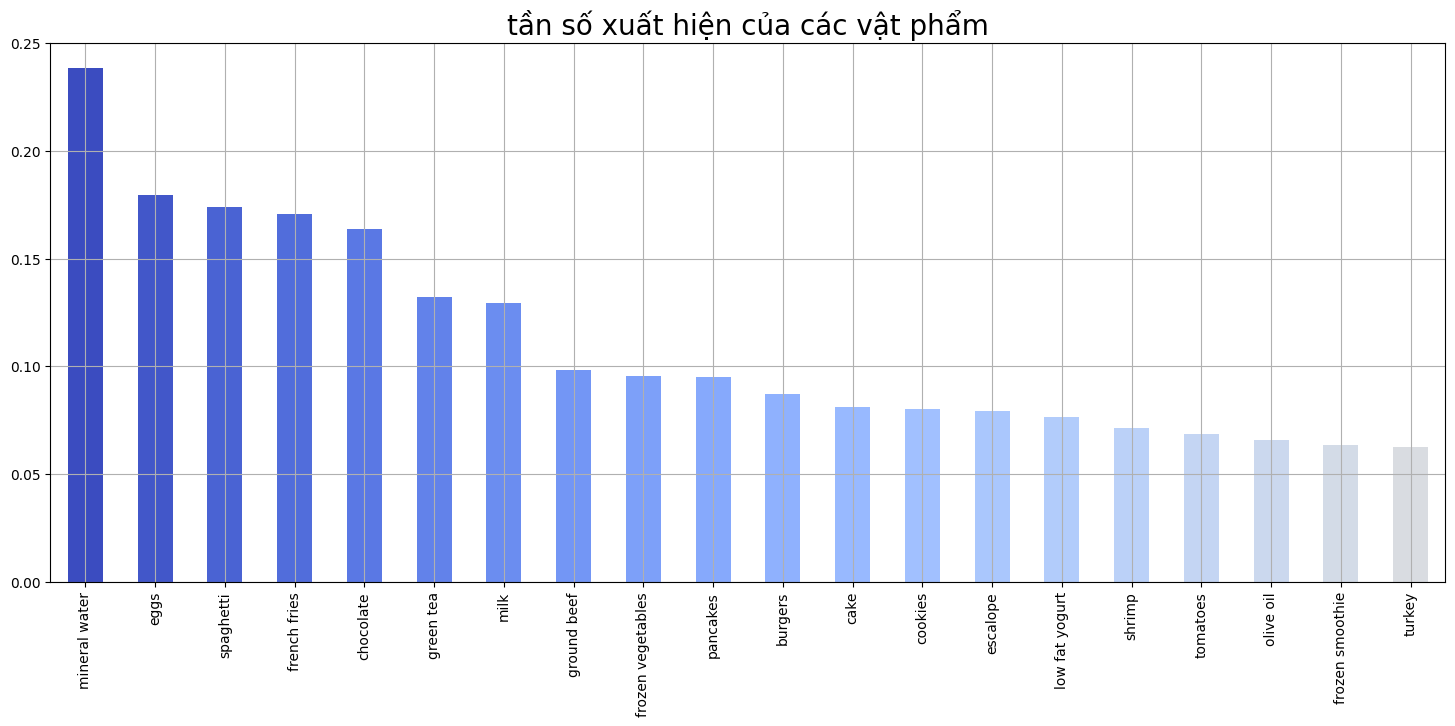

In [27]:
def plotOccurrence(df, n=20, ascending=False):
    """
    đưa ra bảng biểu diễn các vật phẩm có gia trị support cao nhất : tỷ lệ hay tần suất xuất hiện của vật phẩm trong tất cả các đơn hàng
    
    """
    plt.rcParams['figure.figsize'] = (18, 7)
    color = plt.cm.coolwarm(np.linspace(0, 1, 40))
    (df.sum() / df.shape[0]).sort_values(ascending=ascending).head(n).plot.bar(color = color)
    plt.title('tần số xuất hiện của các vật phẩm', fontsize = 20)
    plt.xticks(rotation = 90 )
    plt.grid()
    plt.show()
    
plotOccurrence(df, n=20) # Mineral Water có tỷ lệ xuất hiện cao nhất trong các giao dịch

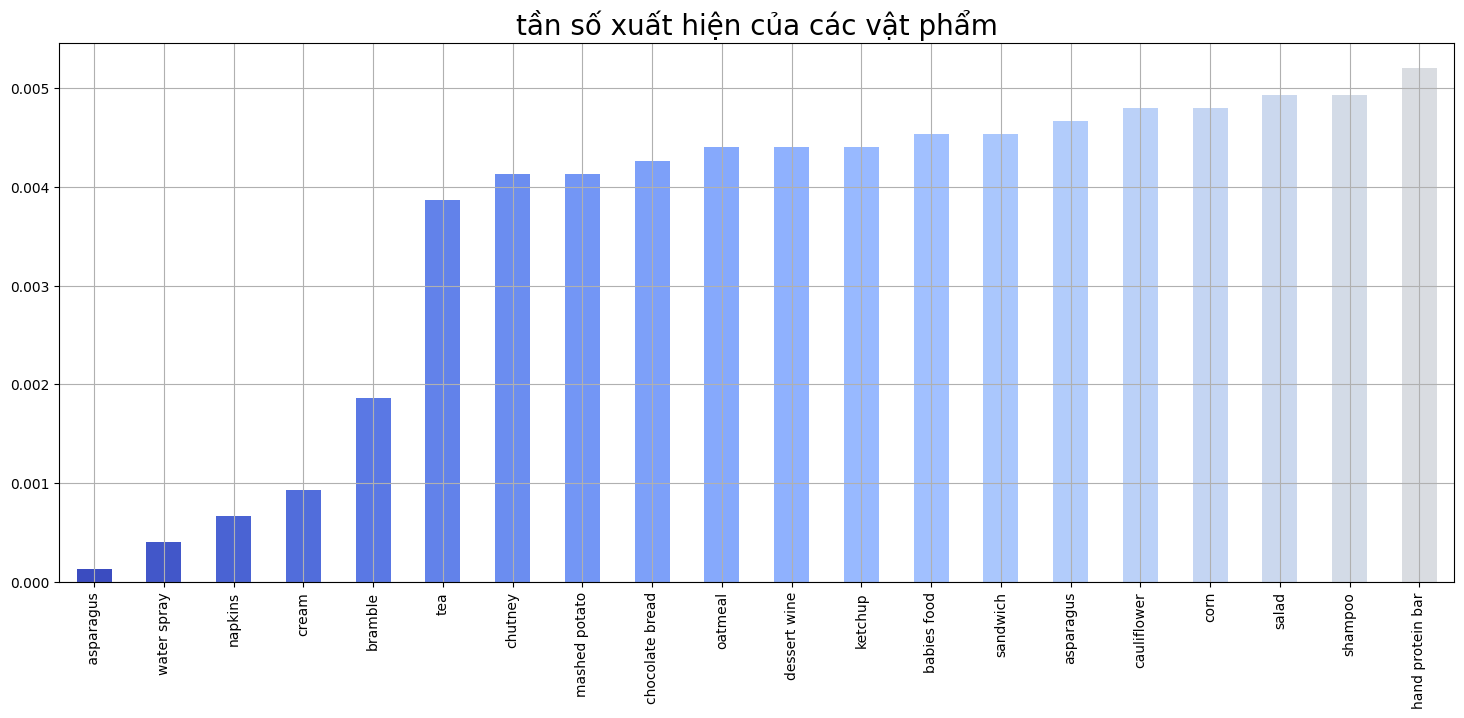

In [28]:
plotOccurrence(df, n=20, ascending=True) # Water Spray có tỷ lệ xuất hiện thấp nhất trong các giao dịch

# Thực hiện tìm tri thức hay các luật 

In [31]:
def getDataBasisMetric(df, min_support=0.02, min_threshold=0.5, metric='confidence', ascending=False):
    
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True )
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    return rules.sort_values(by=metric, ascending=ascending)


# Nếu không có rule để giảm không gian tìm kiếm thì tập luật ta tìm sẽ phải quét qua 2^d với d là số sản phẩm
# min_support : tỷ lê tập giao dịch có sự xuất hiện của itemset với tỷ lệ thấp nhất là min_support
# ví dụ khi giá trị được truyền vào ở dưới là 0.04 thì  item đó phải xuất hiện trong 7501 * 0.04 giao dịch.
# min_threshold : ngưỡng tối thiểu để đánh giá tìm ra tập luật được sử dụng, ở dưới là sử dụng lift

#eg: getDataBasisMetric(df, min_support=0.04, min_threshold=0.5, metric='lift').sort_values("lift", ascending=False)

In [32]:
#thực hiện chạy apriori 
sorted_rules = getDataBasisMetric(df, min_support=0.016, min_threshold=0.2, metric='confidence').sort_values("support", ascending=True)
sorted_rules

/opt/homebrew/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,(tomatoes),(frozen vegetables),0.068,0.095,0.016,0.236,2.474,0.010,1.184
44,(herb & pepper),(spaghetti),0.049,0.174,0.016,0.329,1.889,0.008,1.231
37,(escalope),(french fries),0.079,0.171,0.016,0.207,1.210,0.003,1.045
42,(olive oil),(chocolate),0.066,0.164,0.016,0.249,1.520,0.006,1.113
30,(grated cheese),(spaghetti),0.052,0.174,0.017,0.316,1.812,0.007,1.207
...,...,...,...,...,...,...,...,...,...
29,(eggs),(mineral water),0.180,0.238,0.051,0.283,1.189,0.008,1.063
74,(mineral water),(chocolate),0.238,0.164,0.053,0.221,1.348,0.014,1.073
75,(chocolate),(mineral water),0.164,0.238,0.053,0.321,1.348,0.014,1.122
66,(spaghetti),(mineral water),0.174,0.238,0.060,0.343,1.439,0.018,1.159


In [34]:
# Thực hiện export các rules đã được phát hiện ra file pickle
# sorted_rules.to_pickle("/content/drive/MyDrive/Dataset/sorted_rules.pkl")
sorted_rules.to_pickle("./Output/sorted_rules.pkl")

# Sử dụng các luật đã được tạo ra ở trên và thực hiện đưa ra các recommend dựa theo input

### Metrics để hiểu các luật :

- confidence(A→C) = $ \frac{support(A→C)} {support(A)}$ , range: [0,1]

- lift(A→C) = $ \frac{confidence(A→C)}{support(C)}$ , range: [0,∞]

- leverage(A→C) = $ support(A→C) - support(A) × support(C)$ , range: [−1,1]

- conviction(A→C) = $ \frac{1 − support(C)}{1−confidence(A→C)}$ , range: [0,∞]

In [35]:
#sau khi tạo ra tập luật thì có thể chỉ cần import tập luật vào và dựa vào hàm phía dưới để in ra list item được recommend
# sorted_rules = pd.read_pickle("/content/drive/MyDrive/Dataset/sorted_rules.pkl")
sorted_rules = pd.read_pickle("./Output/sorted_rules.pkl")
sorted_rules[ (sorted_rules['lift'] > 1.1) ] #in ra các luật với lift > 1.1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,(tomatoes),(frozen vegetables),0.068,0.095,0.016,0.236,2.474,0.010,1.184
44,(herb & pepper),(spaghetti),0.049,0.174,0.016,0.329,1.889,0.008,1.231
37,(escalope),(french fries),0.079,0.171,0.016,0.207,1.210,0.003,1.045
42,(olive oil),(chocolate),0.066,0.164,0.016,0.249,1.520,0.006,1.113
30,(grated cheese),(spaghetti),0.052,0.174,0.017,0.316,1.812,0.007,1.207
...,...,...,...,...,...,...,...,...,...
29,(eggs),(mineral water),0.180,0.238,0.051,0.283,1.189,0.008,1.063
74,(mineral water),(chocolate),0.238,0.164,0.053,0.221,1.348,0.014,1.073
75,(chocolate),(mineral water),0.164,0.238,0.053,0.321,1.348,0.014,1.122
66,(spaghetti),(mineral water),0.174,0.238,0.060,0.343,1.439,0.018,1.159


In [38]:
list_of_items_in_cart =['eggs','shrimp']

def recommendation_list(purchased_items, rules_provided):
    recommendation_list = []
    rules_used = []
    for idx, product in enumerate(rules_provided["antecedents"]):
      #lần lượt kiểm tra nếu các vật phẩm trong card là subset của vế trái tập luật 
      for j in list(product):
        if ( product.issubset(purchased_items) ): #Các điều kiện khác cần kiểm tra về lift, leverage, conviction hay confidence sẽ được lọc từ tập rule rồi mới pass vào hàm
            rules_used.append(list(rules_provided.iloc[idx]))
            #Thực hiện add các item ở vế phải luật vào trong recommendation list
            for f in list(rules_provided.iloc[idx]["consequents"]):
              recommendation_list.append(f)
            recommendation_list = list(dict.fromkeys(recommendation_list))

    return rules_used, recommendation_list

rules_used, recommendation_items_list = recommendation_list(list_of_items_in_cart, sorted_rules)

rules_used = pd.DataFrame(rules_used, columns=['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'leverage', 'conviction'])
rules_used.sort_values("lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(shrimp),(frozen vegetables),0.071,0.095,0.017,0.233,2.447,0.010,1.180
1,(shrimp),(milk),0.071,0.130,0.018,0.246,1.900,0.008,1.155
3,(shrimp),(spaghetti),0.071,0.174,0.021,0.297,1.704,0.009,1.174
2,(shrimp),(chocolate),0.071,0.164,0.018,0.252,1.537,0.006,1.118
4,(shrimp),(mineral water),0.071,0.238,0.024,0.330,1.385,0.007,1.137
7,(eggs),(mineral water),0.180,0.238,0.051,0.283,1.189,0.008,1.063
5,(eggs),(french fries),0.180,0.171,0.036,0.203,1.185,0.006,1.040
6,(eggs),(spaghetti),0.180,0.174,0.037,0.203,1.167,0.005,1.037


In [39]:
print(recommendation_items_list)
len(recommendation_items_list)

['frozen vegetables', 'milk', 'chocolate', 'spaghetti', 'mineral water', 'french fries']


6

# Đánh giá tập luật được tạo ra

In [65]:
def cramers_v(confusion_matrix):
    """ 
    tính giá trị Cramers V để tìm categorial-categorial association.
    coi các vật phẩm và sự xuất hiện của chúng trong giao dịch ở đây là categories 
    Giá trị càng gần 0 càng thể hiện hai vật phẩm này là độc lập về sự xuất hiện, càng gần 1 càng thể hiện sự liên quan về sự xuất hiện
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [66]:
def find_association_with_cramers_v(data, columns, plot = True, returnCorr= False):
    """
    tìm mối quan hệ (association) bằng Cramer 

    """
    
    df = data
    cols = columns
    corrM = np.zeros((len(cols),len(cols)))
    np.fill_diagonal(corrM, 1)

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v((pd.crosstab(df[col1], df[col2])).values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    
    corr = round(corr, 2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    if plot:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax = sns.heatmap(corr, cmap='coolwarm', annot=True, ax=ax, mask=mask, 
                         vmax=1.0, vmin=-1.0, linewidths=0.1,
                        annot_kws={"size": 9}, square=True, cbar=True); 
        ax.set_title("Sự tương quan giữa các vật phẩm dựa trên cramers v");

        plt.savefig("./Output/association.png", dpi = 300);
        plt.show()
    
    if returnCorr:
        return corr

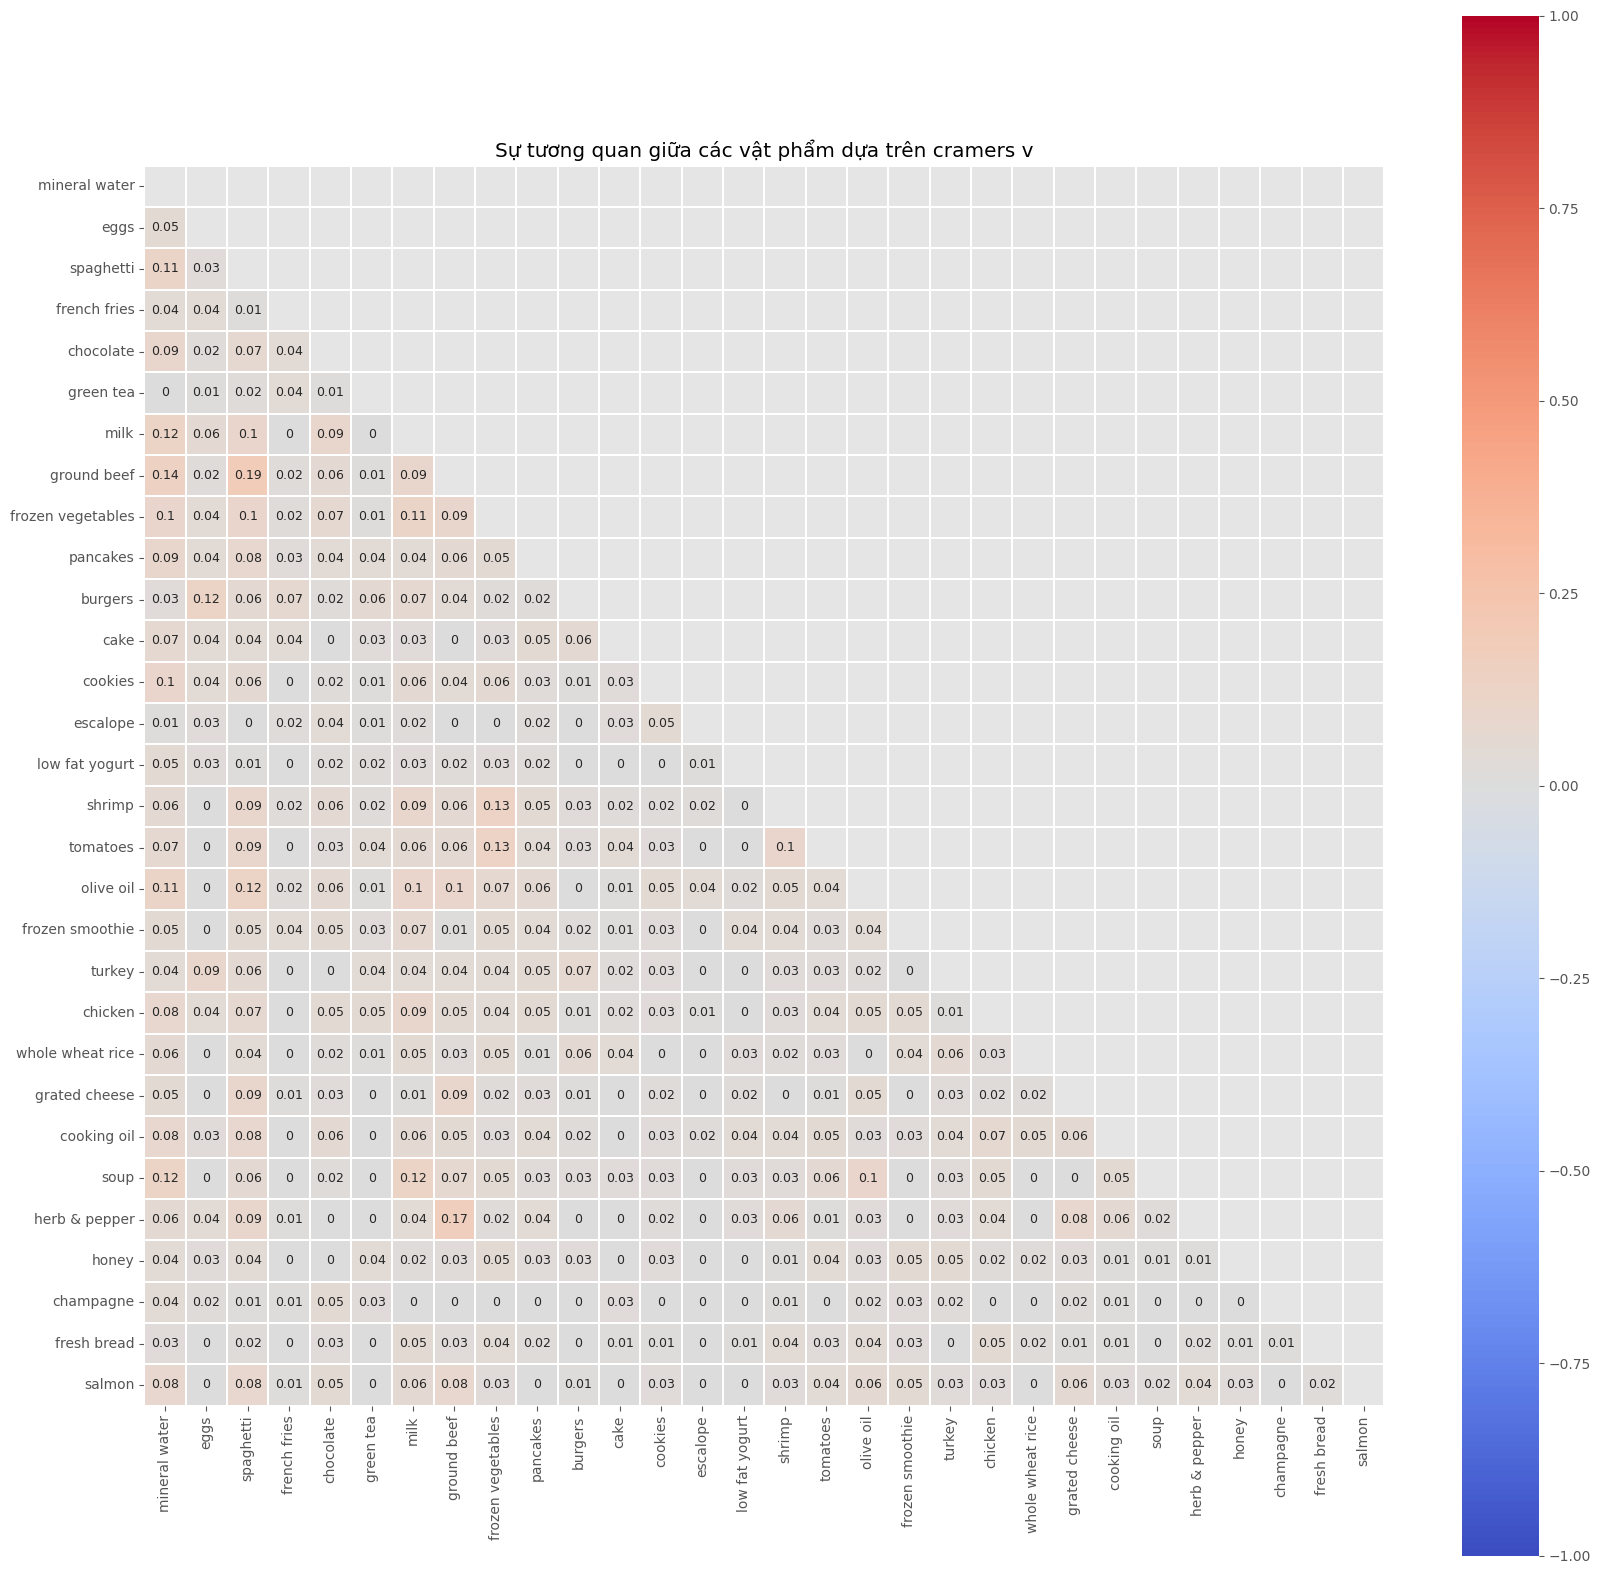

In [67]:
cols = (df.sum() / df.shape[0]).sort_values(ascending=False).head(30).index.tolist()
find_association_with_cramers_v(df, cols)

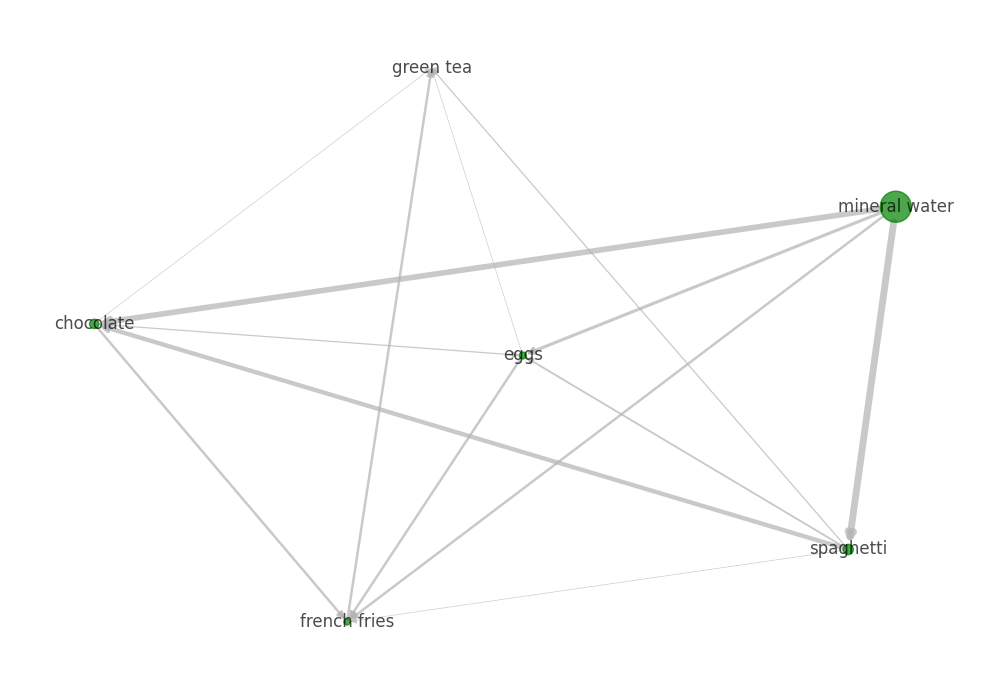

In [47]:
def drawCorrelationGraph(df, startNode):
    """
    Nhận input là dataframe và thực hiện vẽ đồ thị dựa vào mối quan hệ (association) giữa các vật phẩm. 
    Cạnh được cân bằng correlation
    Input: là dataframe của các giao dịch, khởi tạo graph từ start node
    
    """
    weightDict = {}
    cols = (df.sum() / df.shape[0]).sort_values(ascending=False).head(6).index.tolist()
    corrDf = find_association_with_cramers_v( df, cols, plot=False, returnCorr=True)
    weights = corrDf[startNode].sort_values(ascending=False)

    for key, value in zip(weights.index.tolist(), weights.values.tolist()):
        weightDict[key] = value

    combs = [x for x in itertools.combinations(weightDict.keys(), 2)]
    
    edge_width = [round(45 * corrDf[u][v] , 3) for u, v in combs]
    
    G = nx.Graph()
    plt.figure(figsize =(10, 7))
    G.add_node(startNode)
    for items in weightDict.keys():
        G.add_node(items)

    for items in combs:
        G.add_edge(items[0], items[1])
    
    pos = nx.fruchterman_reingold_layout(G)

    nx.draw_networkx(G, pos, with_labels = True, arrowstyle='-|>',
                     alpha = 0.7, width = edge_width,
                     arrows=True, node_size = weights * 500,
                     edge_color ='.7', node_color ='green') 
    
    plt.axis('off')
    plt.tight_layout();
    
drawCorrelationGraph(df, startNode = 'mineral water')

- Có thể thấy từ các trường hợp (mineral water) & (milk, spaghetti,..) : leverage gần 0 mang ý nghĩa 2 vế độc lập; conviction gần bằng 1 cũng thể hiện diều đó. Lift thì lại thể hiện giá trị lớn hơn > 1, cần có thêm phương pháp khác để thể hiện mối quan hệ này, việc sử dụng support & confidence không đủ để đánh giá các luật mà tập data có nhiều giá trị null (bị lệch).

In [49]:
data = getDataBasisMetric(df, min_support=0.016, min_threshold=0.2, metric='confidence')
data[data['antecedents'] == {'mineral water'}].sort_values(by=['lift'], ascending=False) # xác nhận correlation của  mineral water

/opt/homebrew/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,(mineral water),(milk),0.238,0.130,0.048,0.201,1.554,0.017,1.090
67,(mineral water),(spaghetti),0.238,0.174,0.060,0.251,1.439,0.018,1.102
74,(mineral water),(chocolate),0.238,0.164,0.053,0.221,1.348,0.014,1.073
28,(mineral water),(eggs),0.238,0.180,0.051,0.214,1.189,0.008,1.043


In [51]:
def buildContingencyTable(df, antecedant, precedant):
    data_crosstab = pd.crosstab(df[antecedant], df[precedant], rownames = [antecedant.upper()],
                                colnames=[precedant.upper()], margins = True)
    
    print("\nPivot :")
    print(data_crosstab)
    
    crosstab, resChi , expected = researchpy.crosstab(df[antecedant], df[precedant], 
                                                      test= "chi-square", expected_freqs= True);
    
    print('\nExpected Values')
    print(expected)
    
    print("\nPearson Chi-square :", round(resChi.values[0][1], 3))
    

In [52]:
buildContingencyTable(df, antecedant = 'mineral water', precedant = 'milk')   


Pivot :
MILK              0    1   All
MINERAL WATER                 
0              5101  612  5713
1              1428  360  1788
All            6529  972  7501

Expected Values
                   milk        
milk                  0       1
mineral water                  
0             4,972.694 740.306
1             1,556.306 231.694

Pearson Chi-square : 107.178


##### (milk)(mineral water) hiếm hơn (~ milk)(mineral water) & (milk)(~ mineral water) nhưng lại có rất nhiều (~ milk)(~ mineral water) -> rất nhiều giao dịch khôgn có cả sữa và mineral water (rất nhiều giá trị null của hai cột này)

-  lift = 1.554 > 1 thể hiện chúng có sự tương quan mua nước thì mua sữa.
- χ2 = 107.178 , quan sát được[mineral water & milk] (360) > expected (231.694) thể hiện độ tương quan giữa chúng

 Rất hiếm có các trường hợp Milk và Mineral Water cùng xuất hiện trong một giao dịch, có thể thấy hai cách tính thông qua lift và χ2 không hiệu quả với các cặp data lệch bởi các giao dịch null.

**Note** : cả Lift & χ2 đều không hoạt động tốt với nhiều giá trị null xuất hiện ở hai cặp, chính vì vậy ta nên dùng Kulczynski và Imbalance Ratio để đánh giá các trường hợp cặp data bị lệch vì null.


##### Kulczynski= $ 1/2( \frac{S(A U B)}{S(A)} + \frac{S(A U B)}{S(B)} ) $

##### IR= $ \frac{|support(A) - support(B)|} {|support(A)+support(B)- support(A∪B)|} $

In [55]:
def validateMetric(df, antecedents, consequents, min_support=0.016, min_threshold=0.2, metric='confidence'):
    """
    Nếu Kulczynski gần 1 hoặc 0, thì chúng ta đang có một rule với khả năng theo chiều tích cực hoặc ngược lại.
    nếu Kulczynski trả về giá trị gần 0.5 thì khả năng cao luật này không hay
    Imbalance Ratio ở 0 thể hiện sự cân bằng tuyệt đối và gần 1 thể hiện độ lệch lớn trong dataset
    có thể kết luận luật không thú vị được rút ra sẽ có Kulczynski=0.5 và IR=0.
    
    Input : 
    df : dataframe của các giao dịch đã được đưa về dạng nhị phân
    antecedents : vế nếu
    consequents : vế thì
    min_support : giá trị thấp nhất của support   
    min_threshold : ngưỡng thấp nhất để prune dựa theo metric
    metric : Confidence/Lift
    
    """
    data = getDataBasisMetric(df, min_support, min_threshold, metric)
    PA = data[(data['antecedents'] == {antecedents}) & (data['consequents'] == {consequents})]

    kulczynski = round(0.5 * PA['support'].values[0] * \
                       ((1/PA['antecedent support'].values[0]) + (1/PA['consequent support'].values[0])), 4)

    IR = round((PA['antecedent support'].values[0] - PA['consequent support'].values[0])/ \
    (PA['antecedent support'].values[0] + PA['consequent support'].values[0] - PA['support'].values[0]) , 3)
    
    print(f"Kulczynski : {kulczynski} ; Imbalance Ratio : {IR}")


In [56]:
validateMetric(df, antecedents='mineral water', consequents='milk', 
               min_support=0.016, min_threshold=0.2, metric='confidence')

Kulczynski : 0.2859 ; Imbalance Ratio : 0.34


/opt/homebrew/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Một ví dụ nữa

In [57]:
buildContingencyTable(df, antecedant = 'mineral water', precedant = 'spaghetti')   


Pivot :
SPAGHETTI         0     1   All
MINERAL WATER                  
0              4855   858  5713
1              1340   448  1788
All            6195  1306  7501

Expected Values
              spaghetti        
spaghetti             0       1
mineral water                  
0             4,718.309 994.691
1             1,476.691 311.309

Pearson Chi-square : 95.416


In [58]:
validateMetric(df, antecedents='mineral water', consequents='spaghetti', 
               min_support=0.01, min_threshold=0.2, metric='confidence')

# Tỷ lệ dataset với Imblance Ratio là 0,182 thể hiện độ lệch của data, cùng với  Kulczynski là 0.2968 có thể rút ra người dùng không thường xuyên mua mineral water cùng spaghetti mặc dù lift là 1.44

Kulczynski : 0.2968 ; Imbalance Ratio : 0.182


/opt/homebrew/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


#### Kết luận

- Lift, χ2 sẽ là framework tốt nếu các giao dịch không có quá nhiều trường null
- nếu không, Kulczynski + Imbalance Ratio nên được sử dụng để đánh giá luật có dùng được hay không

/opt/homebrew/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


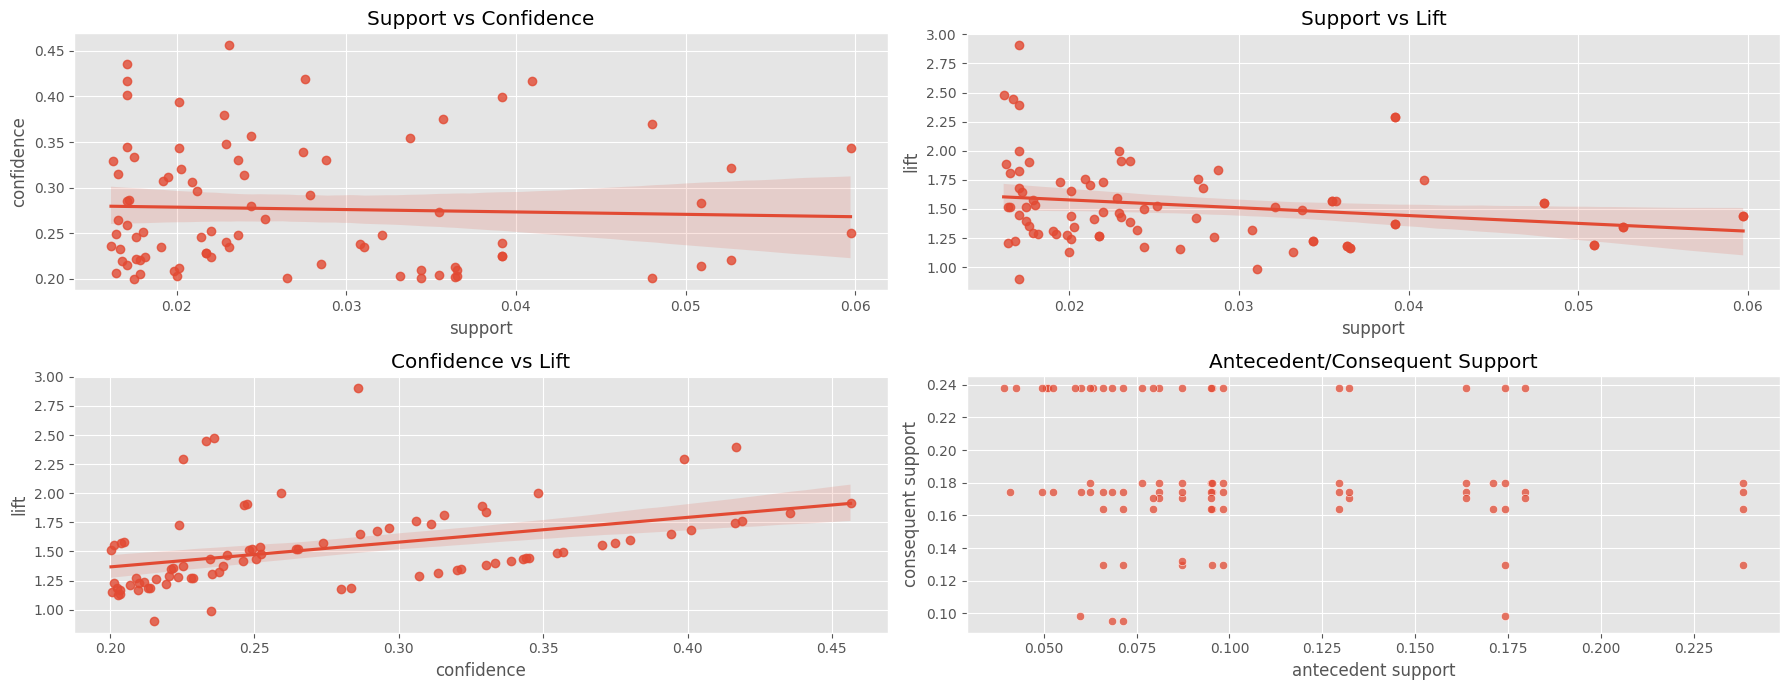

In [59]:
def metricsPlot(rules, alpha=0.95):
    
    titles = ["Support vs Confidence", "Support vs Lift", 
              "Confidence vs Lift", "Antecedent/Consequent Support"]
        
    plt.style.use('ggplot')
    plt.subplot(221)
    plt.title(titles[0])
    sns.regplot(x="support", y="confidence", data=rules)
    plt.subplot(222)
    plt.title(titles[1])
    sns.regplot(x="support", y="lift", data=rules)
    plt.subplot(223)
    plt.title(titles[2])
    sns.regplot(x="confidence", y="lift", data=rules)
    plt.subplot(224)
    plt.title(titles[3])
    sns.scatterplot(x="antecedent support", y="consequent support", data=rules, alpha=alpha)
    plt.tight_layout()
        
        
rules = getDataBasisMetric(df, min_support=0.016, min_threshold=0.2, metric='confidence')
metricsPlot(rules, alpha=0.75)

# Đánh giá tập luật dựa trên dữ liệu của tập test